## Hecho por: David Ramírez Betancourth
## C.C. 1002636667
## Ingeniería Electrónica
## Universidad Nacional de Colombia Sede Manizales

In [2]:
import matplotlib.pyplot as plt #Graficador
import numpy as np #Opearciones entre arrays
import scipy.signal as sig #métodos de señales (welch)


import tensorflow as tf # Red Neuronal
from sklearn.model_selection import train_test_split #Divisor de datos de entrenamiento y testeo
from sklearn.preprocessing import MinMaxScaler #Normalizador de escala
from tensorflow.keras.models import Sequential #Red Neuronal
from tensorflow.keras.layers import Dense, Dropout #Conexión neuronas
from tensorflow.keras.optimizers import Adam #Optimizador de red

#Generar Señal

$f_o = 1 Hz$

$x(t) = cos(\omega_o) - \frac{sin(3\omega_o)}{3} + \frac{cos(5\omega_o)}{5}$

$\xi(t) = x(t) + \eta(t)$

Aplicar método welch: Consiste en hallar la FFT por ventaneos de la señal y luego promediando las PSD de cada segmento

In [3]:
np.random.seed(0)

def randomvector(N, sigma):
    """Genera un vector gaussiano eta = N(0, sigma)"""

    return np.random.normal(0, np.sqrt(sigma), size=N) 

def real_signal(t, wo):
    """x(t)"""

    return np.cos(wo*t) - (1/3)*np.sin(3*wo*t) + (1/5)*np.cos(5*wo*t)


def welch_vector(X, fs, nperseg):
    """Generar psd de la señal xi
       ventaneo hamming
       overlap del 25% de la vetana
    """

    return sig.welch(X, fs, window='hamming', nperseg=nperseg, noverlap=(nperseg*.25))

N = 1024 #Longitud señal
M = 2000 # No de señales
fo = 1 # 1Hz frecuencia
wo = 2*np.pi*fo
sigma = 0.1  #varianza
nperseg = 501 #Longitud ventana

t = np.linspace(0, 3, N) # vector de tiempo de 0 a 3 segundos
fs = 1/(t[1]-t[0]) #Muestreo

X = np.zeros((M, N)) #Matriz vacía de zeros
for i in range(M):
    X_true = real_signal(t, wo) #Generar señal real
    X[i] = X_true + randomvector(N, sigma) #Combinarla con ruido, meterla a la fila

Psd = np.zeros((M, (nperseg//2)+1)) # Matriz welch, M señales, longitud psd = (ventaneo//2) +1
for i in range(M):
    f, psd = welch_vector(X[i], fs, nperseg)
    Psd[i] = psd



# Preparar Datos

Scaler: normaliza los datos a una escala deseada (0,1)

train test split: Divide los datos un porcentaje deseado 70/30, 70 entrenar, 30 test.

In [4]:
scaler = MinMaxScaler(feature_range=(0, 1))

X = scaler.fit_transform(X)
Psd = scaler.fit_transform(Psd)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, Psd, test_size=0.3, random_state=42)

In [5]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1400, 1024)
(600, 1024)
(1400, 251)
(600, 251)


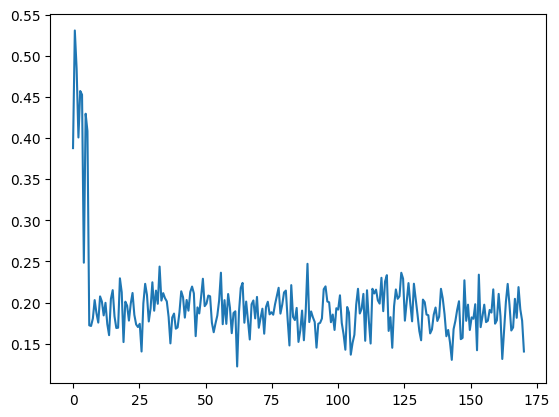

In [6]:
y_train_mean = np.mean(y_train, axis=0)

# Red Neuronal

Modelo tipo Sequential(MLP): Las capas se apilan una tras otra, lo que hace que el flujo de datos sea simple y directo. Es MLP porque contiene perceptrones. Capa de entrada - capa oculta - capa de salida. Configuración Dense.

Optimizador Adam: Utiliza AdaGrad y RMSProp. Consiste en:
- Calcular Gradiente
- Se corrige sesgos
- Se actualizan pesos
 



In [14]:
model = Sequential([
    tf.keras.Input(shape=(N,)), #Capa de entrada
    Dense(N//2, activation='relu'), #Capa oculta
    Dropout(0.5), #Dropout para no sobreajuste
    Dense(N//4, activation='relu'), # Capa oculta
    Dense(128, activation='relu'), #Capa oculta
    Dense(nperseg//2 + 1) #Capa de salida
])

model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=['accuracy']) #Optimizador adam, 

history = model.fit(X_train, y_train, epochs=50, validation_split=0.2)

Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.0029 - loss: 0.0851 - val_accuracy: 0.0036 - val_loss: 0.0467
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0018 - loss: 0.0465 - val_accuracy: 0.0071 - val_loss: 0.0355
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0094 - loss: 0.0362 - val_accuracy: 0.0250 - val_loss: 0.0282
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0108 - loss: 0.0288 - val_accuracy: 0.0429 - val_loss: 0.0238
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0262 - loss: 0.0247 - val_accuracy: 0.0357 - val_loss: 0.0210
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0336 - loss: 0.0222 - val_accuracy: 0.0179 - val_loss: 0.0201
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0349 - loss: 0.0213 - val_accuracy: 0.0250 - val_loss: 0.0196
Epoch 8/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0443 - loss: 0.0208 - val_accuracy: 0.0321 - val_loss

# Rendimiento del Modelo

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0448 - loss: 0.0195 
Test Loss: 0.01930893398821354, Test MAE: 0.0533333346247673


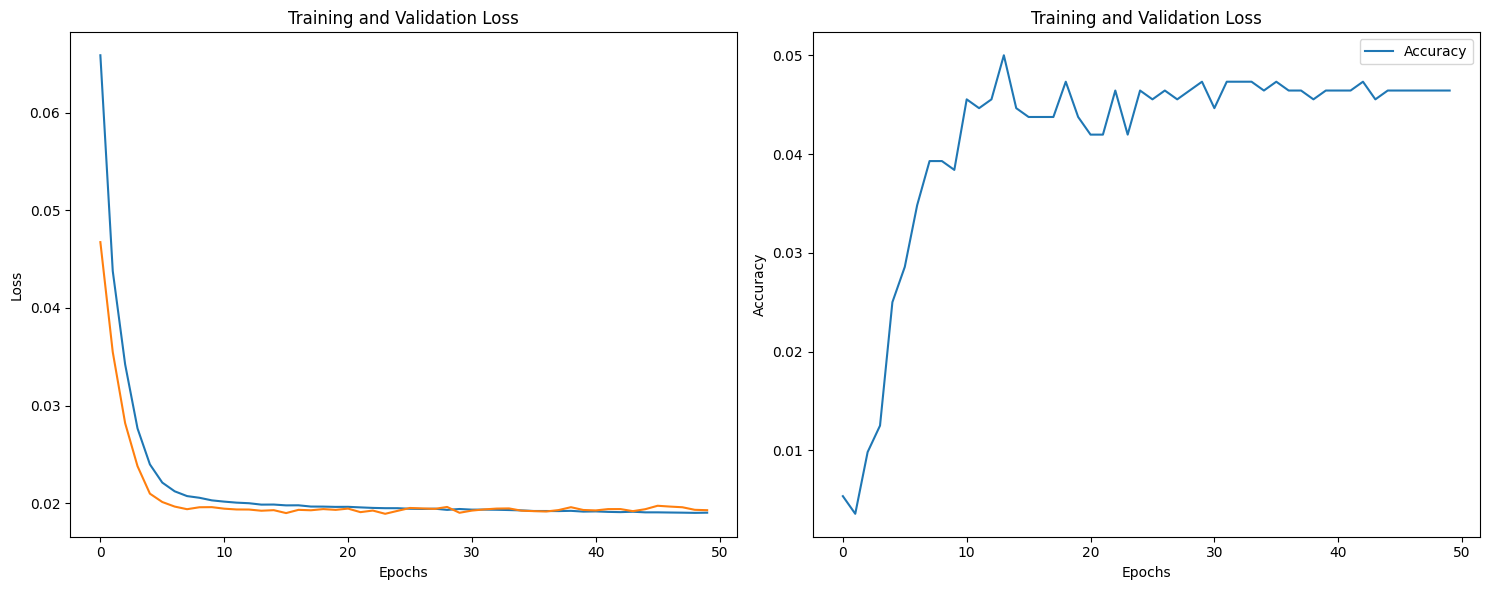

In [15]:
# Evaluar modelo
loss, mae = model.evaluate(X_test, y_test) #Saca mae = promedio del error absoluto y pérdidas del modelo
print(f"Test Loss: {loss}, Test MAE: {mae}")


fig, axs = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(15, 6)
axs[0].plot(history.history['loss'], label='Training Loss')
axs[0].plot(history.history['val_loss'], label='Validation Loss')
axs[0].set_title('Training and Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[1].plot(history.history['accuracy'], label='Accuracy')
axs[1].set_title('Training and Validation Loss')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

# Predecir

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


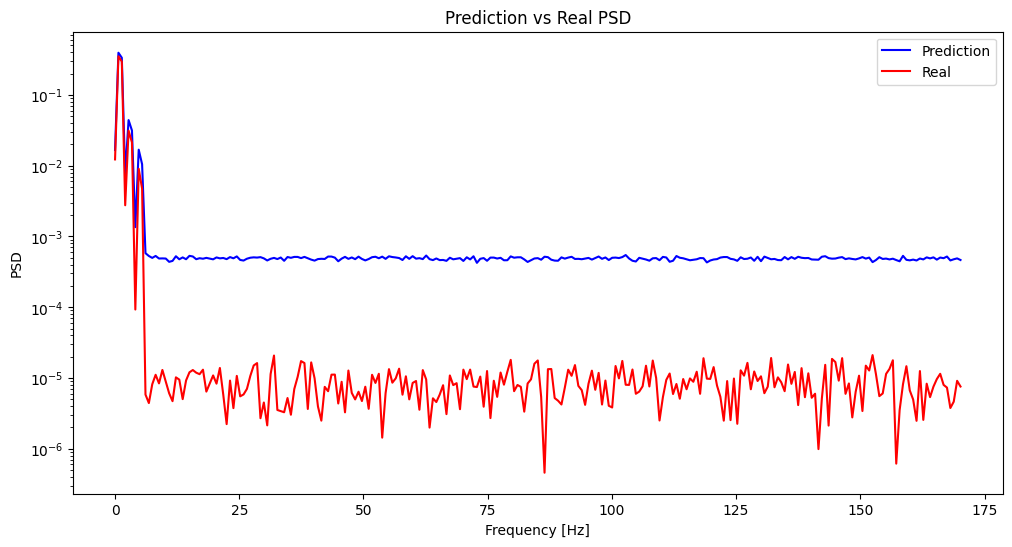

In [9]:
psd_pred = model.predict(X_test)
psd_pred = scaler.inverse_transform(psd_pred)

psd_real = np.zeros((M, (nperseg//2)+1))
for i in range(X_test.shape[0]):
    f, psd = welch_vector(X_test[i], fs, nperseg)
    psd_real[i] = psd
psd_real = scaler.inverse_transform(psd_real)

plt.figure(figsize=(12, 6))
plt.semilogy(f, psd_pred[50], color='b', label='Prediction')
plt.semilogy(f, psd_real[50], color='r', label='Real')
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD')
plt.title('Prediction vs Real PSD')
plt.legend()
plt.show()

# Reconstrucción 

- Comparar la reconstrucción del psd_real vs psd_predict

- Hallar la gráfica de la varianza del ruido vs error para varias señales

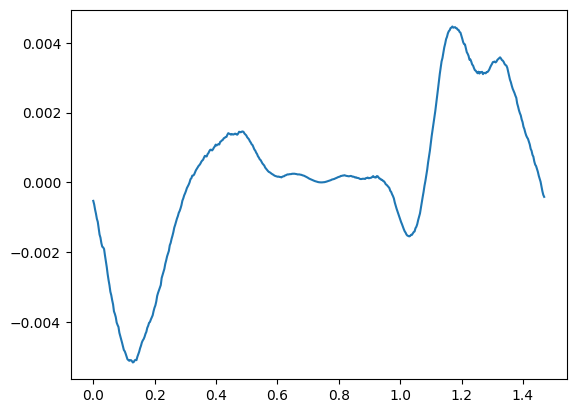

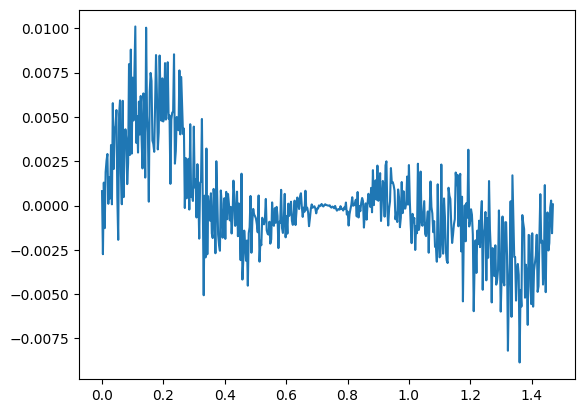

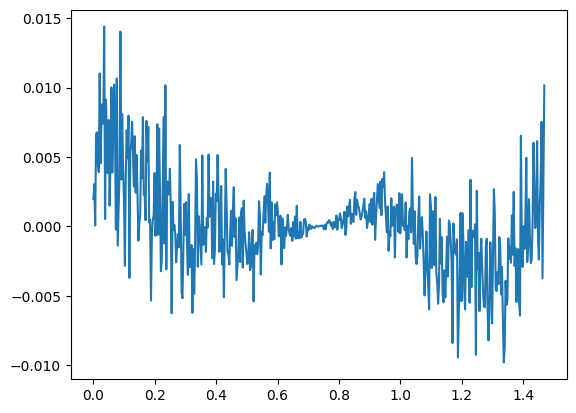

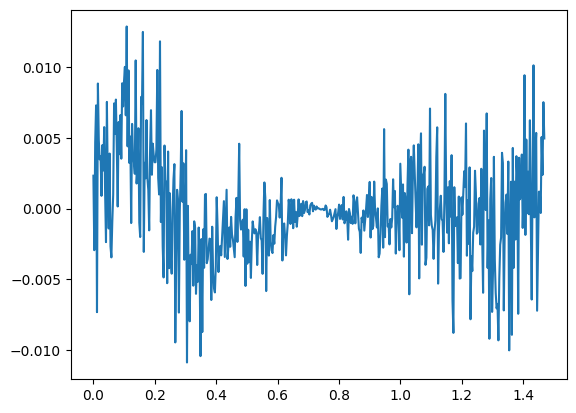

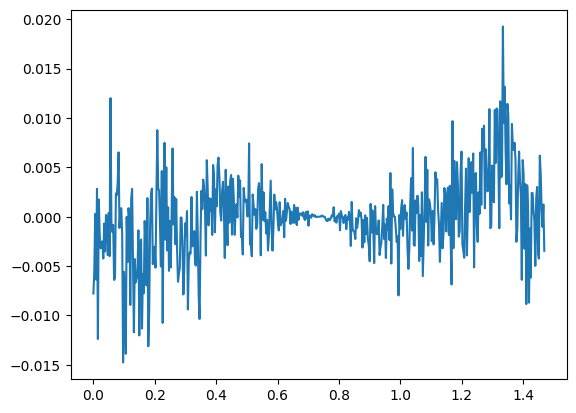

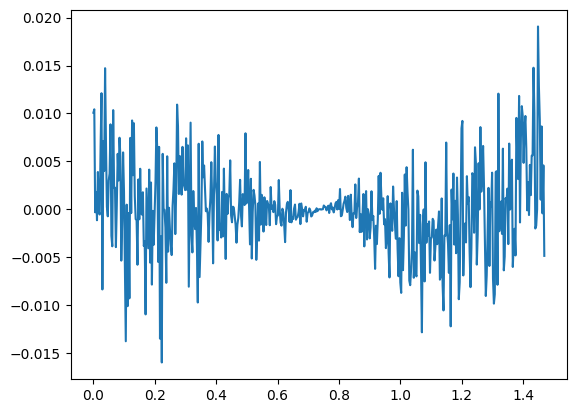

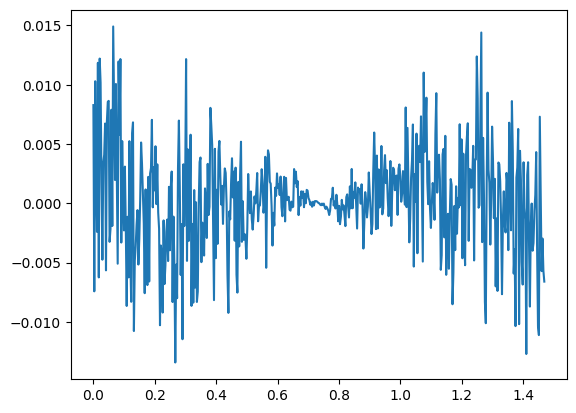

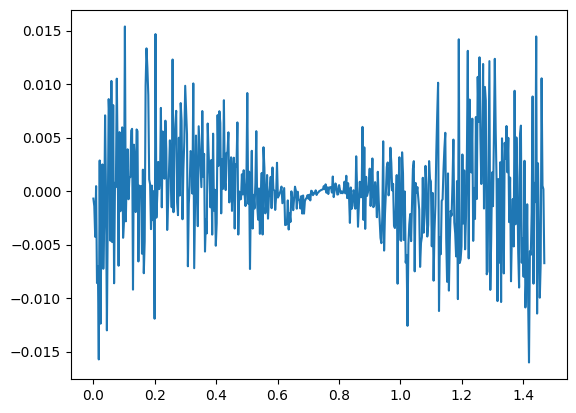

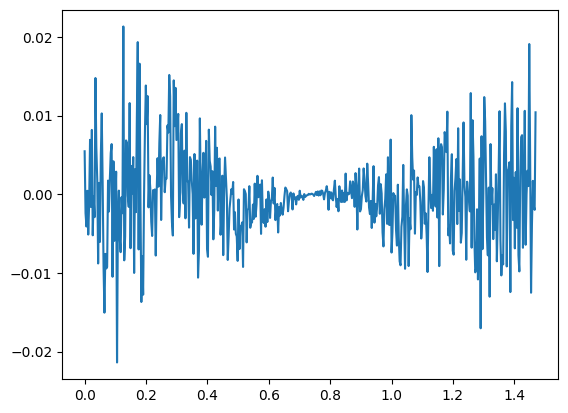

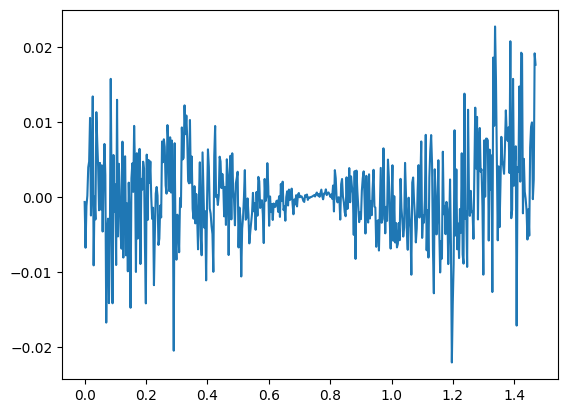

In [36]:
np.random.seed(0)

def reconstruir_senal(f, psd, t):

    # Convertir la PSD en la magnitud del espectro de frecuencia
    magnitud = np.sqrt(psd)

    # Crear un espectro complejo con magnitud y fase aleatoria
    
    fase_aleatoria = np.exp(1j * np.random.uniform(0, 2 * np.pi, len(f)))
    espectro = magnitud * fase_aleatoria

    # Duplicar el espectro para considerar las frecuencias negativas
    espectro_completo = np.concatenate([espectro, np.conj(espectro[::-1])])

    # Realizar la IFFT para obtener la señal en el dominio temporal
    senal = np.fft.ifft(espectro_completo)

    # Asegurar que la señal resultante sea real
    senal_real = np.real(senal)

    return senal_real[:len(t)]

rec_real = reconstruir_senal(f, psd_real[100], t)
rec_pred = reconstruir_senal(f,psd_real[100], t)
t_rec = t[0:502]


"""plt.figure(figsize=(12,6))
plt.plot(t_rec, rec_real, label='real')
plt.plot(t_rec, rec_pred, label='pred')
plt.legend()
plt.show()"""



N_sigma = 10

sigma = np.linspace(0, 5, N_sigma)

x_noise_variable = np.zeros((N_sigma,N))
psd_real_m = np.zeros((N_sigma,(nperseg//2 +1)))

for i in range(len(sigma)):

    x = real_signal(t,wo) + randomvector(N,sigma[i])
    f, psd_real = welch_vector(x, fs, 501)

    x_noise_variable[i] = x
    psd_real_m[i] = psd_real

    x_real= reconstruir_senal(f, psd_real_m[i], t)

    plt.plot(t_rec, x_real)
    plt.show()


# Umbral adaptativo

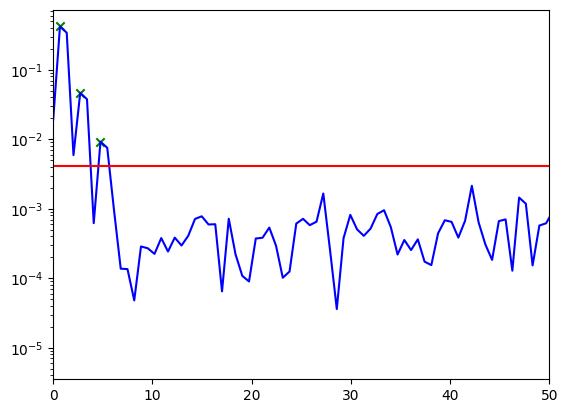

In [11]:
def thresholding_harmonics(f, psd):

    psd_mean = np.mean(psd)

    peaks, _ = sig.find_peaks(psd, height=psd_mean, distance=1)

    peaks_filtered = peaks[psd[peaks] > psd_mean] #filtrar picos
    # Paso 3: Obtener las coordenadas
    harm_f = f[peaks_filtered]
    harm_psd = psd[peaks_filtered]


    return psd_mean, harm_f, harm_psd


t = np.linspace(0,3,N)
fo = 1
wo = 2*np.pi*fo

x = real_signal(t, wo)

sigma = 0.1  #varianza
nperseg = 501 #Longitud ventana
fs = 1/(t[1]-t[0]) #Muestreo

X = x + randomvector(N, sigma)

f, Psd = welch_vector(X, fs, nperseg)

thres, harm_f, harm_psd = thresholding_harmonics(f, Psd)

plt.semilogy(f, Psd, c='b')
plt.semilogy(f, np.full(len(f), thres), c='r')
plt.scatter(harm_f, harm_psd,  marker='x', c='g')

plt.xlim([0,50])
plt.show()

# Señal reconstruida mediante umbral

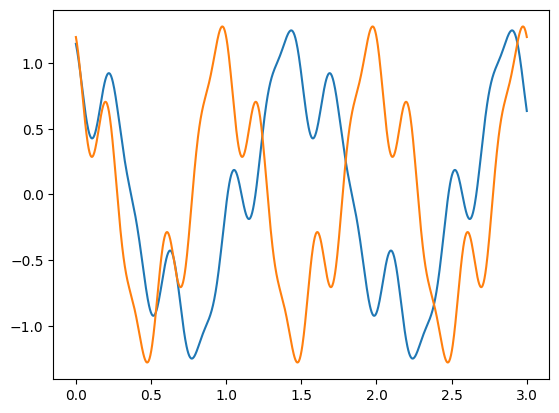

In [12]:
psd_normalized = harm_psd/(harm_psd.max())
psd_vector = np.sqrt(psd_normalized)

#Reconstruir señal

rec_signal = psd_vector[0]*np.cos(2*np.pi*harm_f[0]*t) - psd_vector[1]*np.sin(2*np.pi*harm_f[1]*t) + psd_vector[2]*np.cos(2*np.pi*harm_f[2]*t)

plt.plot(t, rec_signal)
plt.plot(t, real_signal(t,wo))